In [2]:
circuit_df = pd.read_csv("data/circuits.csv")

In [3]:
import pandas as pd
from datetime import datetime, time
from meteostat import Hourly, Stations
from concurrent.futures import ThreadPoolExecutor

# List of circuit information with special times
special_circuits = {
    "bahrain": {"time_range": (time(17, 0), time(23, 0))},
    "marina_bay": {"time_range": (time(17, 0), time(23, 0))},
    "las_vegas": {"time_range": (time(17, 0), time(23, 0))},
    "yas_marina": {"time_range": (time(17, 0), time(23, 0))},
    "jeddah": {"time_range": (time(17, 0), time(23, 0))},
}


# Set time periods
start_2012 = datetime(2012, 3, 15)
end_2012 = datetime(2012, 11, 30, 23, 59)
start_2022 = datetime(2022, 3, 15)
end_2022 = datetime(2022, 11, 30, 23, 59)

# Create a DataFrame to store aggregated data
all_data = pd.DataFrame()

def fetch_data(circuit_info):
    station = Stations().nearby(circuit_info["lat"], circuit_info["lng"]).fetch(1)
    if station.empty:
        return circuit_info["name"], pd.DataFrame()

    data = Hourly(station.index[0], start_2012, end_2012)
    return circuit_info["name"], data.fetch()

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(fetch_data, circuit) for _, circuit in circuit_df.iterrows()]

for future in futures:
    try:
        circuit_name, data = future.result()

        # Fetch the circuit's information from the CSV
        circuit_info = circuit_df[circuit_df['name'] == circuit_name].iloc[0]

        if circuit_name in special_circuits:
            start_time, end_time = special_circuits[circuit_name]["time_range"]
            filtered_data = data[(data.index.time >= start_time) & (data.index.time <= end_time)]
        else:
            # Convert index to DatetimeIndex
            data.index = pd.to_datetime(data.index)
            filtered_data = data[(data.index.dayofweek == 6) & (data.index.time >= time(14, 30)) & (data.index.time <= time(17, 0))]
        
        # Reset the index and create a new "time" and "name" column
        filtered_data = filtered_data.reset_index()
        filtered_data["time"] = filtered_data["time"].apply(lambda x: x.time())
        filtered_data["name"] = circuit_name



        all_data = pd.concat([all_data, filtered_data])
    except Exception as e:
        print(f"Error fetching data for circuit {circuit_name}: {e}")

# Print the aggregated data for all circuits
print(all_data)














         time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun   
0    15:00:00  11.8  10.7  93.0   NaN   NaN  310.0  13.0   NaN  1022.7   NaN  \
1    16:00:00  11.8  11.0  95.0   NaN   NaN  320.0  13.0   NaN  1022.7   NaN   
2    15:00:00  12.2   9.9  86.0   NaN   NaN  190.0   5.4   NaN  1023.1   NaN   
3    16:00:00  11.4   9.5  88.0   NaN   NaN  200.0   9.4   NaN  1022.9   NaN   
4    15:00:00   9.7   8.3  91.0   NaN   NaN   80.0  13.0   NaN  1017.2   NaN   
..        ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   ...   
106  16:00:00  26.1  17.7  60.0   0.0   NaN  360.0  20.5   NaN  1019.3   NaN   
107  17:00:00  27.2  18.2  58.0   0.0   NaN   40.0  22.3   NaN  1018.9   NaN   
108  15:00:00  18.3  12.3  68.0   0.0   NaN  310.0   9.4   NaN  1021.0   NaN   
109  16:00:00  20.6  12.3  59.0   0.0   NaN  320.0  16.6   NaN  1021.2   NaN   
110  17:00:00  21.7  12.3  55.0   0.0   NaN    NaN  11.2   NaN  1020.7   NaN   

     coco                            na

In [4]:
# Specify the column to move
column_to_move = 'name'

# Extract the column to be moved
moved_column = all_data[column_to_move]

# Drop the column from its original position
df_f1_circuit_weather = all_data.drop(column_to_move, axis=1)

# Insert the column at the beginning of the DataFrame
df_f1_circuit_weather.insert(0, column_to_move, moved_column)

print(df_f1_circuit_weather)

                               name      time  temp  dwpt  rhum  prcp  snow   
0    Albert Park Grand Prix Circuit  15:00:00  11.8  10.7  93.0   NaN   NaN  \
1    Albert Park Grand Prix Circuit  16:00:00  11.8  11.0  95.0   NaN   NaN   
2    Albert Park Grand Prix Circuit  15:00:00  12.2   9.9  86.0   NaN   NaN   
3    Albert Park Grand Prix Circuit  16:00:00  11.4   9.5  88.0   NaN   NaN   
4    Albert Park Grand Prix Circuit  15:00:00   9.7   8.3  91.0   NaN   NaN   
..                              ...       ...   ...   ...   ...   ...   ...   
106   Miami International Autodrome  16:00:00  26.1  17.7  60.0   0.0   NaN   
107   Miami International Autodrome  17:00:00  27.2  18.2  58.0   0.0   NaN   
108   Miami International Autodrome  15:00:00  18.3  12.3  68.0   0.0   NaN   
109   Miami International Autodrome  16:00:00  20.6  12.3  59.0   0.0   NaN   
110   Miami International Autodrome  17:00:00  21.7  12.3  55.0   0.0   NaN   

      wdir  wspd  wpgt    pres  tsun  coco date hou

In [5]:
unique_prcp_values = data['prcp'].unique()
print(unique_prcp_values)

[ 0.   nan  0.5  0.3  2.3  0.8  9.9  1.   2.5  2.   3.3  1.8  5.3  3.6
  1.3  2.8  4.8  5.8  1.5 13.2  4.6  4.3  8.4  3.  15.5 20.6  4.1  6.4
 18.  10.4 15.7  9.7  5.1  7.6  8.1  5.6 12.2 27.7 17.5  8.9 13.5  9.1
 17.3 19.1  6.1  6.6 16.3  7.1 11.7  7.4 20.1 13.   9.4  3.8 31.2]


### Feature Engineering

Let's create a new column "recommended_tyres" based on precipitation values.
- Intermediate tyres are recommended from 1 to 4mm of precipitation.
- Full wet tyres are recommended if the water on track exceeds 4mm.
- For 0.0 values we assign " dry tyres ".
- For this, we will create bins : 


```[-1, 1)``` (left-closed, right-open): This bin includes precipitation values from greater than -1 mm (since there can't be negative precipitation) to less than 1 mm. The label assigned to this bin is "dry tyres."

```[1, 4]```: This bin includes precipitation values from 1 mm (inclusive) to 4 mm (inclusive). The label assigned to this bin is "intermediate tyres."

```(4, inf)```: This bin includes precipitation values greater than 4 mm. The label assigned to this bin is "full wet tyres."

This classification was based on the website [simracingsetup](https://simracingsetup.com/f1-manager/how-to-manage-your-tyres-in-f1-manager-22-complete-tyre-management-guide/#:~:text=The%20full%20wet%20tyre%20should,on%20track%20exceeds%204%2Bmm])

In [12]:
# Create a new DataFrame with recommended_tyres column
recommended_tyres_data = all_data.copy()

# Define the labels for the bins
bin_labels = ["dry tyres", "intermediate tyres", "full wet tyres"]

# Add the recommended_tyres column based on prcp values
recommended_tyres_data["recommended_tyres"] = pd.cut(
    recommended_tyres_data["prcp"],
    bins=[-1, 1, 4, float('inf')],
    labels=bin_labels,
    right=False  # Use right=False to exclude the right bin edge
)

# Print the aggregated data with the new recommended_tyres column
print(recommended_tyres_data)

         time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun   
0    15:00:00  11.8  10.7  93.0   NaN   NaN  310.0  13.0   NaN  1022.7   NaN  \
1    16:00:00  11.8  11.0  95.0   NaN   NaN  320.0  13.0   NaN  1022.7   NaN   
2    15:00:00  12.2   9.9  86.0   NaN   NaN  190.0   5.4   NaN  1023.1   NaN   
3    16:00:00  11.4   9.5  88.0   NaN   NaN  200.0   9.4   NaN  1022.9   NaN   
4    15:00:00   9.7   8.3  91.0   NaN   NaN   80.0  13.0   NaN  1017.2   NaN   
..        ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   ...   
106  16:00:00  26.1  17.7  60.0   0.0   NaN  360.0  20.5   NaN  1019.3   NaN   
107  17:00:00  27.2  18.2  58.0   0.0   NaN   40.0  22.3   NaN  1018.9   NaN   
108  15:00:00  18.3  12.3  68.0   0.0   NaN  310.0   9.4   NaN  1021.0   NaN   
109  16:00:00  20.6  12.3  59.0   0.0   NaN  320.0  16.6   NaN  1021.2   NaN   
110  17:00:00  21.7  12.3  55.0   0.0   NaN    NaN  11.2   NaN  1020.7   NaN   

     coco                            na

Let's have a look on our table on the new created column

In [15]:
recommended_tyres_data.head(200)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,name,date,hour,recommended_tyres
0,15:00:00,11.8,10.7,93.0,NaN,NaN,310.0,13.0,NaN,1022.7,NaN,NaN,Albert Park Grand Prix Circuit,NaN,NaN,NaN
1,16:00:00,11.8,11.0,95.0,NaN,NaN,320.0,13.0,NaN,1022.7,NaN,NaN,Albert Park Grand Prix Circuit,NaN,NaN,NaN
2,15:00:00,12.2,9.9,86.0,NaN,NaN,190.0,5.4,NaN,1023.1,NaN,NaN,Albert Park Grand Prix Circuit,NaN,NaN,NaN
3,16:00:00,11.4,9.5,88.0,NaN,NaN,200.0,9.4,NaN,1022.9,NaN,NaN,Albert Park Grand Prix Circuit,NaN,NaN,NaN
4,15:00:00,9.7,8.3,91.0,NaN,NaN,80.0,13.0,NaN,1017.2,NaN,NaN,Albert Park Grand Prix Circuit,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,16:00:00,24.0,16.0,61.0,NaN,NaN,90.0,7.6,NaN,NaN,NaN,NaN,Bahrain International Circuit,NaN,NaN,NaN
11,17:00:00,24.0,17.0,65.0,NaN,NaN,120.0,9.4,NaN,NaN,NaN,NaN,Bahrain International Circuit,NaN,NaN,NaN
12,15:00:00,24.0,14.1,54.0,NaN,NaN,70.0,14.8,NaN,NaN,NaN,NaN,Bahrain International Circuit,NaN,NaN,NaN
13,16:00:00,24.0,15.0,57.0,NaN,NaN,70.0,13.0,NaN,NaN,NaN,NaN,Bahrain International Circuit,NaN,NaN,NaN


Now let's check the unique values of our new column "recommended_tyres"

In [14]:
recommended_tyres_data.recommended_tyres.unique()

[NaN, 'dry tyres', 'intermediate tyres', 'full wet tyres']
Categories (3, object): ['dry tyres' < 'intermediate tyres' < 'full wet tyres']

It seems correct, although we have NaN values. These NaN values come from the NaN values in the precipitation column.

Let's check how many NaN we have in this table

In [16]:
recommended_tyres_data.isna().sum()

time                    0
temp                  229
dwpt                  237
rhum                  237
prcp                 4247
snow                 5808
wdir                  844
wspd                  232
wpgt                 5808
pres                 2722
tsun                 5697
coco                 5808
name                    0
date                 5808
hour                 5808
recommended_tyres    4247
dtype: int64

In [18]:
# import missingno
import missingno as msno

<Axes: >

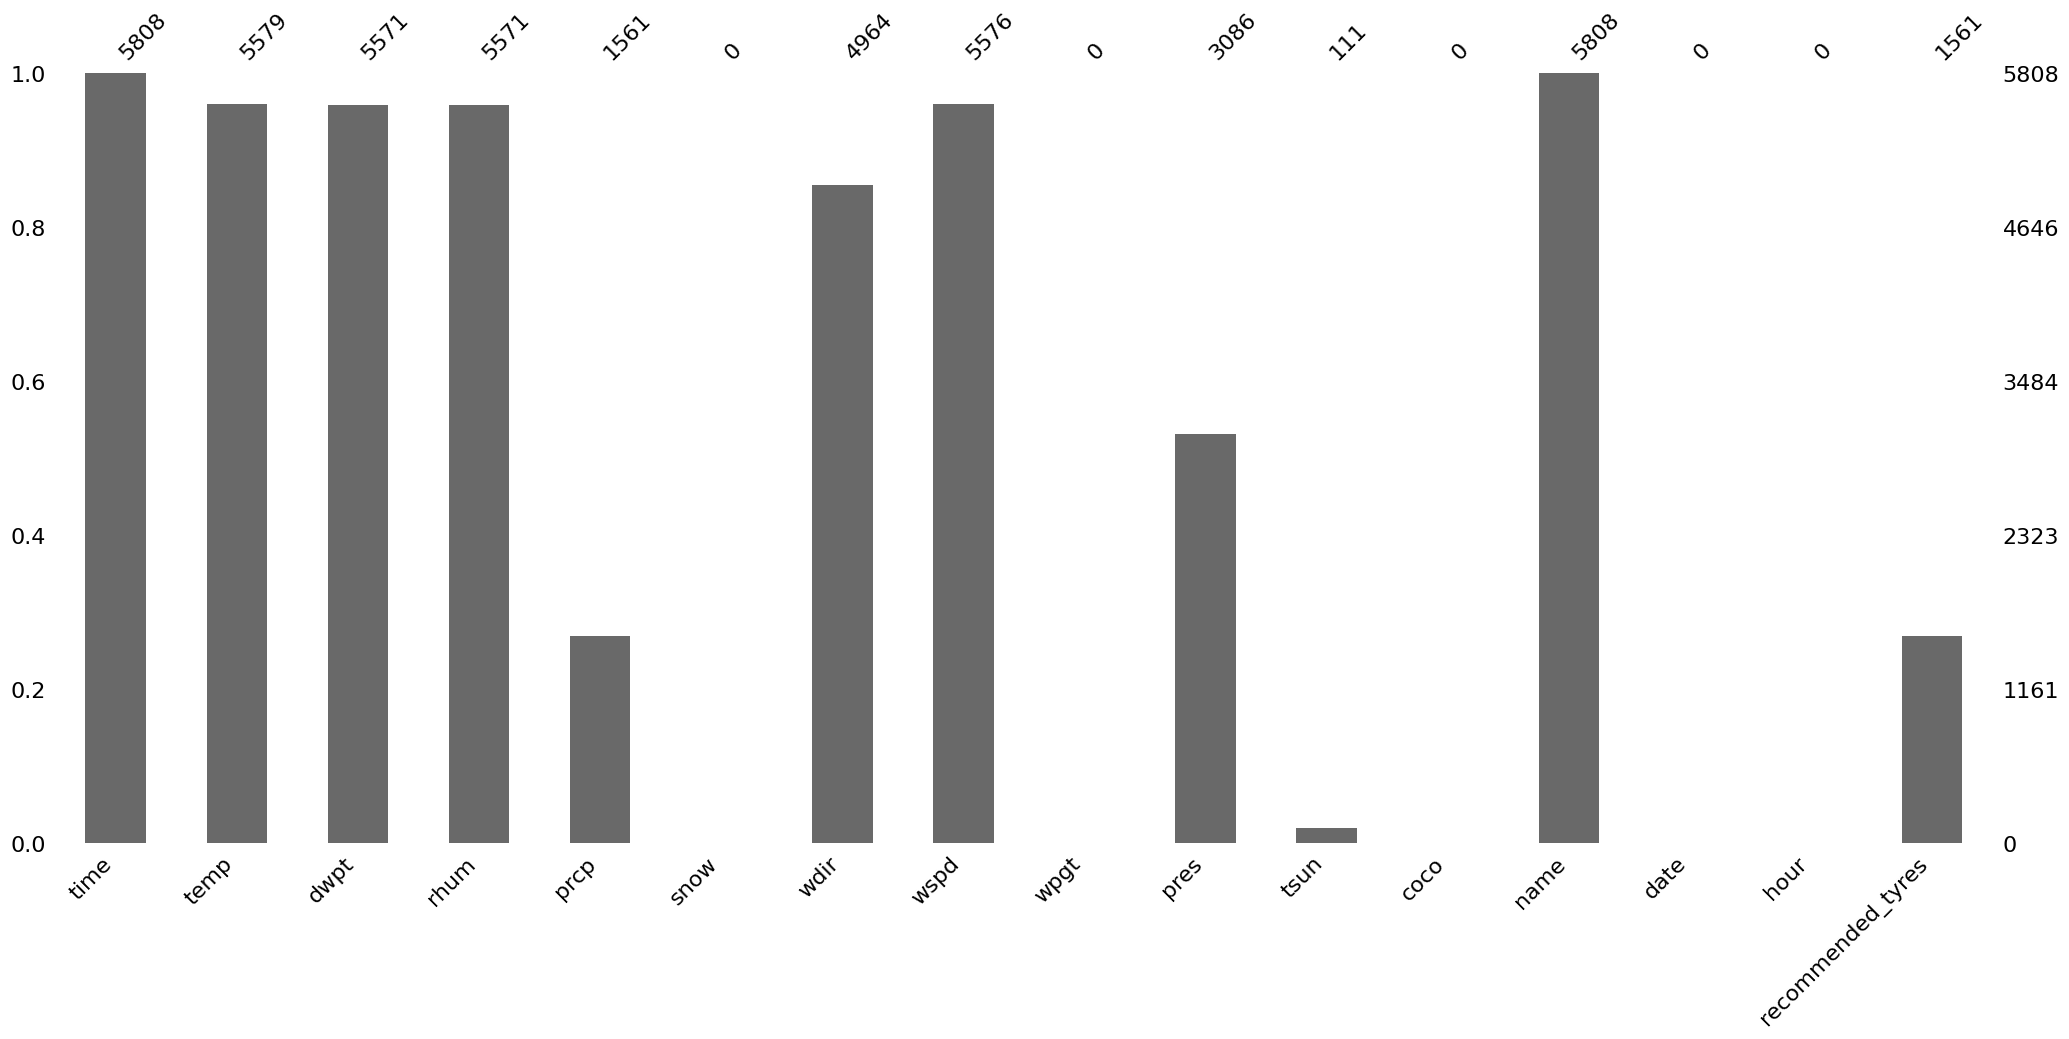

In [20]:
# plotting percentage of missing values per column
msno.bar(recommended_tyres_data)

In [22]:
print(f"numbers of rows : {recommended_tyres_data.shape[0]}")
print(f"missing values in temp : {round(recommended_tyres_data.temp.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in dwpt : {round(recommended_tyres_data.dwpt.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in rhum : {round(recommended_tyres_data.rhum.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in prcp : {round(recommended_tyres_data.prcp.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in snow : {round(recommended_tyres_data.snow.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in wdir : {round(recommended_tyres_data.wdir.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in wspd : {round(recommended_tyres_data.wspd.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in wpgt : {round(recommended_tyres_data.wpgt.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in pres : {round(recommended_tyres_data.pres.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in tsun : {round(recommended_tyres_data.tsun.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in coco : {round(recommended_tyres_data.coco.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in date : {round(recommended_tyres_data.date.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in hour : {round(recommended_tyres_data.hour.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in recommended tyres : {round(recommended_tyres_data.recommended_tyres.isna().sum()/recommended_tyres_data.shape[0]*100,2)} %")
print(f"missing values in data frame : {round(recommended_tyres_data.isna().sum().sum()/(recommended_tyres_data.shape[0]*recommended_tyres_data.shape[1])*100,2)} %")

numbers of rows : 5808
missing values in temp : 3.94 %
missing values in dwpt : 4.08 %
missing values in rhum : 4.08 %
missing values in prcp : 73.12 %
missing values in snow : 100.0 %
missing values in wdir : 14.53 %
missing values in wspd : 3.99 %
missing values in wpgt : 100.0 %
missing values in pres : 46.87 %
missing values in tsun : 98.09 %
missing values in coco : 100.0 %
missing values in date : 100.0 %
missing values in hour : 100.0 %
missing values in recommended tyres : 73.12 %
missing values in data frame : 51.36 %


Precipitation and recommend tyres columns have both the same missing values. 73% is a lot. 



In [23]:
recommended_tyres_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5808 entries, 0 to 110
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   time               5808 non-null   object  
 1   temp               5579 non-null   float64 
 2   dwpt               5571 non-null   float64 
 3   rhum               5571 non-null   float64 
 4   prcp               1561 non-null   float64 
 5   snow               0 non-null      float64 
 6   wdir               4964 non-null   float64 
 7   wspd               5576 non-null   float64 
 8   wpgt               0 non-null      float64 
 9   pres               3086 non-null   float64 
 10  tsun               111 non-null    float64 
 11  coco               0 non-null      float64 
 12  name               5808 non-null   object  
 13  date               0 non-null      object  
 14  hour               0 non-null      object  
 15  recommended_tyres  1561 non-null   category
dtypes: category(

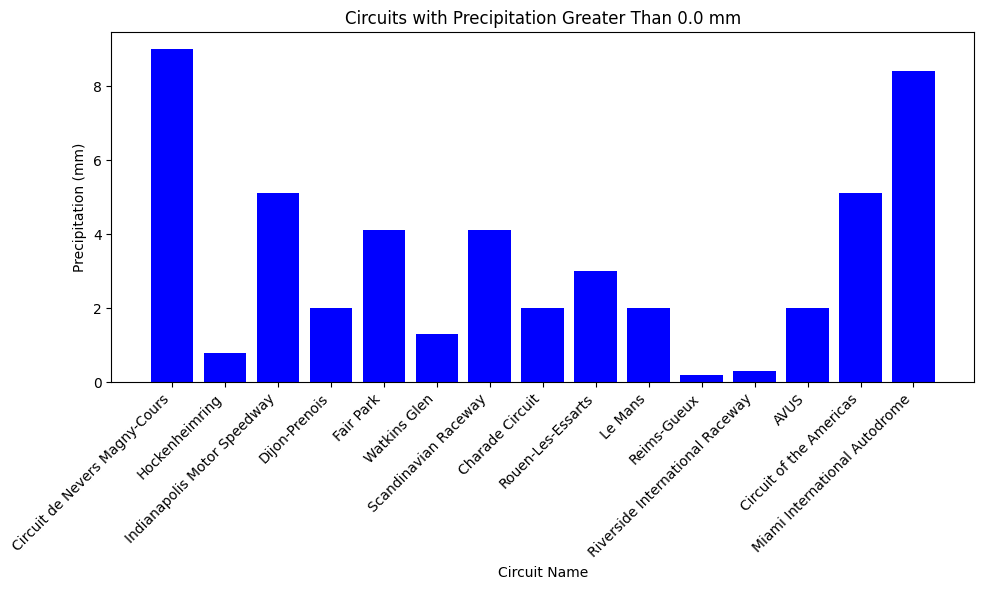

In [25]:
import matplotlib.pyplot as plt

# Filter data for circuits with precipitation greater than 0.0
circuits_with_precipitation = recommended_tyres_data[recommended_tyres_data["prcp"] > 0.0]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(circuits_with_precipitation["name"], circuits_with_precipitation["prcp"], color='blue')
plt.xlabel("Circuit Name")
plt.ylabel("Precipitation (mm)")
plt.title("Circuits with Precipitation Greater Than 0.0 mm")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
print(data.head())  # Print the first few rows of the data
print(data.info())  # Print information about the data (e.g., column data types, missing values)

                     temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres   
time                                                                          
2012-03-15 00:00:00  23.3  15.6  62.0   0.0   NaN  40.0  14.8   NaN  1021.2  \
2012-03-15 01:00:00  22.8  14.9  61.0   0.0   NaN  40.0  16.6   NaN  1021.9   
2012-03-15 02:00:00  22.8  16.1  66.0   0.0   NaN  60.0  20.5   NaN  1022.4   
2012-03-15 03:00:00  22.8  16.1  66.0   0.0   NaN  50.0  18.4   NaN  1022.5   
2012-03-15 04:00:00  22.8  17.7  73.0   NaN   NaN  60.0  18.4   NaN  1022.5   

                     tsun  coco  
time                             
2012-03-15 00:00:00   NaN   NaN  
2012-03-15 01:00:00   NaN   NaN  
2012-03-15 02:00:00   NaN   NaN  
2012-03-15 03:00:00   NaN   NaN  
2012-03-15 04:00:00   NaN   NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6259 entries, 2012-03-15 00:00:00 to 2012-11-30 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -------------- 

In [30]:
# Print the values in the 'prcp' column
print(recommended_tyres_data['prcp'])

# Print unique values in the 'prcp' column
print(recommended_tyres_data['prcp'].unique())

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
106    0.0
107    0.0
108    0.0
109    0.0
110    0.0
Name: prcp, Length: 5808, dtype: float64
[nan 0.2 0.  2.  0.4 9.  1.  0.5 0.8 0.1 0.3 3.3 5.1 3.6 0.6 4.1 1.3 3.
 0.9 4.6 8.4 1.8 2.3 1.5]


In [31]:
# Assuming you have the 'data' DataFrame with the weather data
nan_counts_by_day = recommended_tyres_data['prcp'].groupby(recommended_tyres_data.index.date).apply(lambda x: x.isna().sum())

print(nan_counts_by_day)

AttributeError: 'Index' object has no attribute 'date'